<a href="https://colab.research.google.com/github/francji1/SU2/blob/main/01SU2_2022_Decision_Trees_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hugging decision trees - Lecture + Lab

**Course website:** [www.ml2.cz/labs](http://www.ml2.cz/labs)



## Schedule of today lecture

* Binary Decison Tree
 * Introduction + Algorithms
* Ensemble models
  * Voting
  * Bagging and Pasting¶ 
  * Stacking
* Random Forests
* Adaptive Boosting
  * AdaBoost
* Gradient Boosting
  * XGboost (LightGBM, CatBoost) 
* Explain feature importances via SHAP values



## Literature and sources for today's Lecture + Exercises

* https://github.com/jakevdp/PythonDataScienceHandbook
* https://github.com/ageron/handson-ml2
* https://scikit-learn.org/stable/supervised_learning.html
* https://machinelearningmastery.com/start-here/#xgboost
* https://harvard-iacs.github.io/2018-CS109A/category/lectures.html
* https://christophm.github.io/interpretable-ml-book/
* https://koalaverse.github.io/machine-learning-in-R/decision-trees.html
* https://shap.readthedocs.io/en/latest/


# 1. Decision Trees

* A tree-shaped ML method that can cope with both clssification and regression tasks.
  * Classification Tree: A decision tree that performs classification (predicts a categorical response).
  * Regression Tree: A decision tree that performs regression (predicts a numeric response). 
* Powerful algorithms, easy to train and fit huge datasets with mixed predictors (numeric and categorical).
* Easily interpretable method by humans (white box model with similar approach how humans make decisions - one step at  a time). Harder, but possible for large trees too.
* **The corestone of Random Forests** and other Ensamble methods.


Most implementation in this lecture is from scikit-learn library: https://scikit-learn.org/stable/modules/tree.html


## Motivation and first touch 


Opinion: For tabular data XGBoost/LightGBM is all you need to solve more than 95% of regression/classification **ML tasks**.

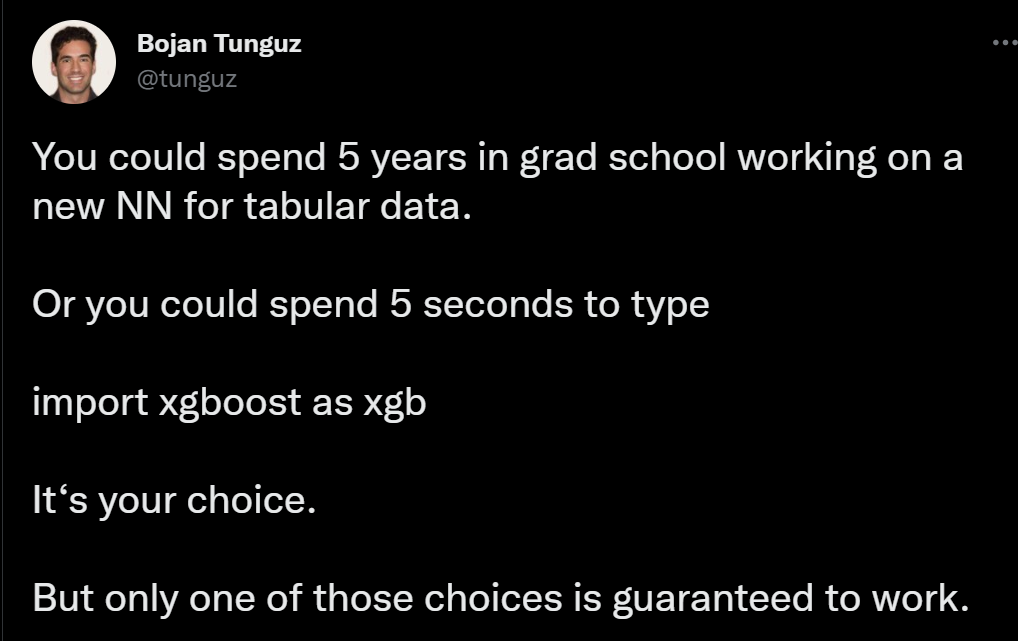

Before importing xgboost lets talk about its roots ;)


#### Lets continue where we finished last time 

##### Import libraries and submodules

In [ ]:
from sklearn import tree
from sklearn.datasets import load_iris, make_blobs, make_moons, make_circles
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, SCORERS

import matplotlib.pyplot as plt  
from matplotlib.colors import ListedColormap

import pandas as pd
from pandas import DataFrame

import numpy as np
import seaborn as sns
import os


iris = load_iris()
iris_pd = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_pd.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [ ]:
#pip freeze # Colab has older version of scikit-learn and other libraries

#from platform import python_version
#print(python_version())

Lets take only 2 dimensional data and use Decision Tree for Classification as a "black box" for a moment.

In [ ]:
X = iris.data[:, 2:] # Lets take only petal length and width into account
y = iris.target

tree_clf0 = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf0.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

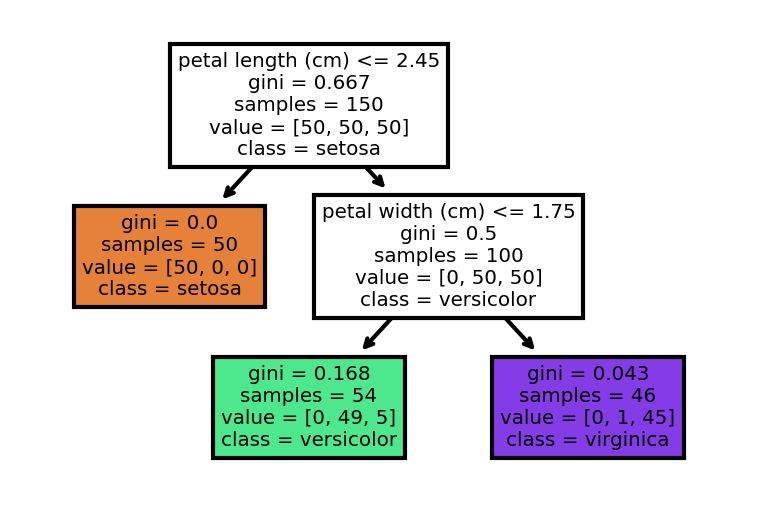

In [ ]:
# To see the graphical visualisation from graphiz as a dot file check:
#https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc
#from graphviz import Source

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,2), dpi=300)
tree.plot_tree(tree_clf0,
               feature_names =['petal length (cm)','petal width (cm)'], 
               class_names=['setosa', 'versicolor', 'virginica'],
               filled = True);

### ✍🏼 Excercise 1.1

We mentioned that Decision Tree is easy to interpret and it can easily estimate the probability that new observation belongs to a particular class `k`:

Suppose we found a flower with folowing parameters:
* `petal length = 4cm ` 
* `petal width = 1.7cm`

What is the probability that this flower corresponds to given class (`setosa`,`versicolor`,`virginica`)? 


In [ ]:
# Your turn:
p_setosa = 0/54
p_versicolor = 49/54
p_virginica = 5/54
print([[p_setosa,p_versicolor,p_virginica]])
tree_clf0.predict_proba([[4,1.7]])


[[0.0, 0.9074074074074074, 0.09259259259259259]]


array([[0.        , 0.90740741, 0.09259259]])

Import some help functions from the Python Data Science Handbook to better visualization of the tree classifier and its boundaries. 

In [ ]:
%%file helpers.py
# Source code: Python Data Science Handbook
# https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/Index.ipynb#scrollTo=KPvyffkaQeEj

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact

def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    #ax.axis('tight')
    #ax.axis('off')
    ax.set_ylabel('ylabel')
    ax.set_xlabel('xlabel')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis')
                          # clim=(y.min(), y.max()),zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1, 2, 3, 4, 5 , 6, 7])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

Writing helpers.py


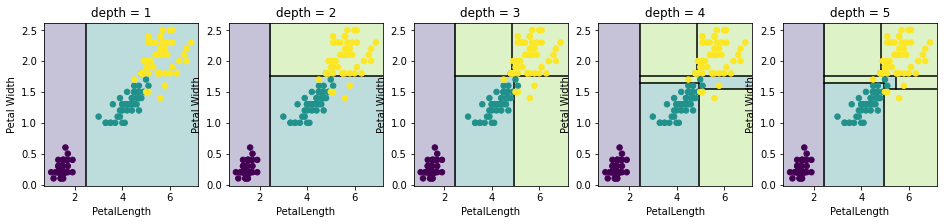

In [ ]:
from helpers import visualize_tree

maximal_depth = 5
fig, ax = plt.subplots(1, maximal_depth, figsize=(16, 3))
#fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)
# Set common labels


#X, y = make_blobs(n_samples=300, centers=4,
#                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, maximal_depth+1)):
    model = DecisionTreeClassifier(max_depth=depth,  random_state=42)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))
    axi.set_xlabel('PetalLength')
    axi.set_ylabel('Petal Width')

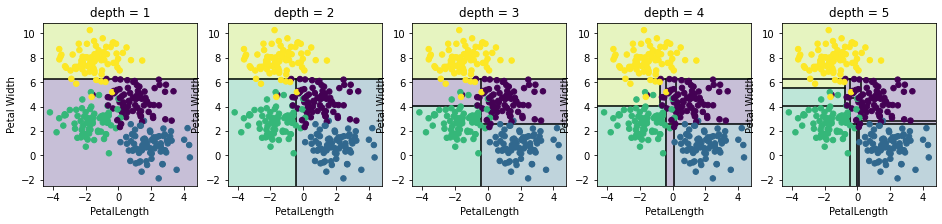

In [ ]:
maximal_depth = 5
fig, ax = plt.subplots(1, maximal_depth, figsize=(16, 3))

X_blob, y_blob = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, maximal_depth+1)):
    model = DecisionTreeClassifier(max_depth=depth,  random_state=42)
    visualize_tree(model, X_blob, y_blob, ax=axi)
    axi.set_title('depth = {0}'.format(depth))
    axi.set_xlabel('PetalLength')
    axi.set_ylabel('Petal Width')

### ✍🏼 Excercise 1.2

Try to increase maximal depth and ansfer folowing questions:

* Why splits differ in each figure?
* Can we keep the first splits same?
* Discus advanteges/disadvanteges of this method based on this "first look".

Task:
* Implement simple binary decision tree for XOR Problem by hand (if and else statements)

http://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html

In [ ]:
x = 1
y = 1

def logical_xor(x, y):
    return bool(x) ^ bool(y)

def dt_xor(x:float, y:float):
    if x > 0.5:
      if y > 0.5:
        result = False
      else: # y < 0.5
        result = True
    else:  # x < 0.5
      if y > 0.5:
        result = True
      else: # y < 0.5
        result = False
    return(result)

print(dt_xor(x,y))
print(logical_xor(x,y))

False
False


## How to build a binary tree?

To build a decision tree model, we take a greedy approach that partitions  the input space and then fit very
simple models to predict the output in each piece:

1. Start with an empty tree.
2. Choose the optimal predictor on which to split and choose the optimal threshold value for splitting by applying a splitting criterion.
3. Recurse on on each new node until stopping condition is met.


The partition in binary tree is described using a "cuts”, which recursively splits the space.

**Methods of building a evaluating a tree can differ by**:
* The class of possible ways to split the space at each node (generally a linear orthogonal splits parallel to the axes of the space).
* The class of predictors within the partitions (generally simply constants).
* The algorithm for making the partitions.



### Algorithms
There are many different algorithms, but all are based on **greedily** constructing a partition. The most used algorithm is CART, introduced by 
Leo Breiman and his coleagues  
Breiman, L., J. Friedman, R. Olshen, and C. Stone, 1984: Classification and regression trees. Wadsworth Books, 358.  
(https://www.stat.berkeley.edu/~breiman/)

Other well known algorithms are ID3, C4.5 or C5.0 all created by Ross Quinlan. 

Some of the differences between CART and C4.5 are:
* Splitings in CART are always binary, but C4.5 allows two or more outcomes.
* The original CART algorithm uses the Gini Impurity, whereas C4.5 use Entropy.
* Different approach to prunning and missing data.

\\

Rules based on variables’ values are selected to get the best split to differentiate observations based on the dependent variable.

Once a rule is selected and splits a node into two, the same process is applied to each “child” node (i.e. it is a recursive procedure).

Splitting stops when the algorithm detects no further gain can be made, or some pre-set stopping rules are met. Or the data are split as much as possible and then the tree is later pruned.



####How to select the splits and how to control complexity? 

We focus on Classification and Regression Tree (CART) algorithm. 

The growing of the tree (training) starts by splitting the training set into 2 subsets using a single feature $k$ and a treshold $t_k$.

There are several cost functions, how to choose the pair $(k,t_k)$.

****

#### CART algorithm cost functions for classification:


For classification, CART algorithm minimize following cost functions (splitting criteria) :

* **Gini Impurity in node $i$**:  
Gini Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset.  
$J(k,t_k) = \frac{m_{2i}}{m} G_{2i} +  \frac{m_{2i+1}}{m} G_{2i+1} =  \frac{m_{2i}}{m} \sum_{j=1}^n ( p_{2i,j} (1- p_{2i,j})) +  \frac{m_{2i+1}}{m} \sum_{j=1}^n ( p_{2i+1,j} (1- p_{2i+1,j})) = \frac{m_{2i}}{m} (1- \sum_{j=1}^n p_{2i,j}^2) +  \frac{m_{2i+1}}{m} (1- \sum_{j=1}^n p_{2i+1,j}^2),$  
where $p_{i,j}$ is the ratio of class $j$ instances among the training instances in the $i^{th}$ node and $m_i$ is the number of instances in this node.  
Gini Impurity  reaches zero when all cases in the node fall into a single target category.

* **Entropy in node $i$**:  
Entropy is a measure of the amount of uncertainty in the data.
$J(k,t_k) = \frac{m_{2i}}{m} H_{2i} +  \frac{m_{2i+1}}{m} H_{2i+1} =  \frac{m_{2i}}{m} (- \sum_{j=1}^n p_{2i,j} log(p_{2i,j})) +  \frac{m_{2i+1}}{m} (- \sum_{j=1}^n p_{2i+1,j} log(p_{2i+1,j})).$  
Entropy of the node is zero when all instances in the node is perfectly classified.


* **Misclassification Error**  
$J(k,t_k) =  \frac{m_{2i}}{m} (1 - p_{2i,j(j)}) +  \frac{m_{2i+1}}{m} (1 - p_{2i+1,j(j)}),$  
where $p_{i,j(j)}$ is the ratio of right assigned instances in the $i^{th}$ node. Note: (Accuracy = 1 - Misclassification Rate).



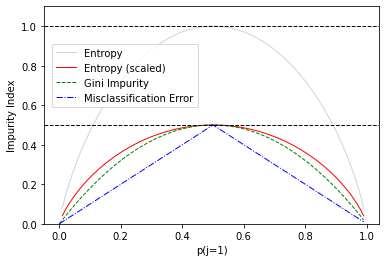

In [ ]:
# code from: https://www.bogotobogo.com/python/scikit-learn/scikt_machine_learning_Decision_Tree_Learning_Informatioin_Gain_IG_Impurity_Entropy_Gini_Classification_Error.php
def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=1, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85),
         ncol=1, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()

Hint: Use concave cost functions such as Enropy or Gini. Misclassification Error can stuck in case of zero information gain.

Question: Does a child node always have a lower value of the cost function (Entropy/Gini/...) than its parent node?

Calculate the information gain in example from the beginning:

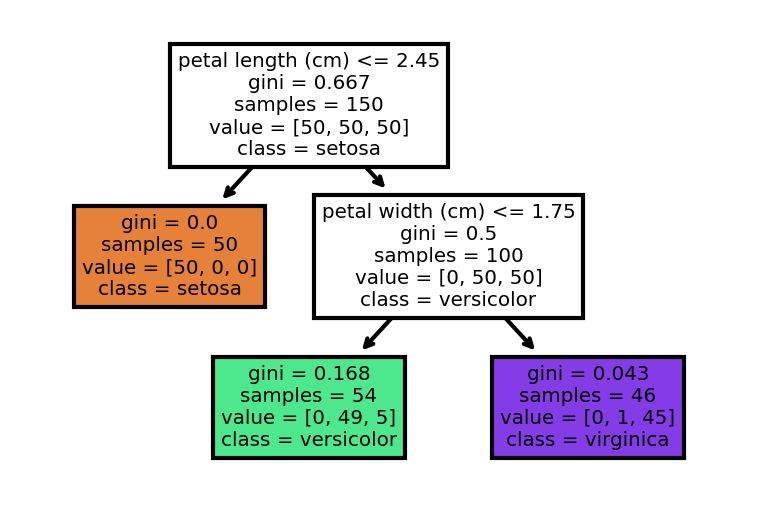

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,2), dpi=300)
tree.plot_tree(tree_clf0,
               feature_names =['petal length (cm)','petal width (cm)'], 
               class_names=['setosa', 'versicolor', 'virginica'],
               filled = True);

For more detail explanation: https://www.youtube.com/watch?v=cLWZVinpAu0

#### CART algorithm cost functions for regression:


For regression, CART algorithm minimize following cost functions :

* **MSE in node $i$**:  
$J(k,t_k) = \frac{m_{2i}}{m} MSE_{2i} +  \frac{m_{2i+1}}{m} MSE_{2i+1} =  \frac{m_{2i}}{m} \sum_{l \in (node \ 2i)} (\hat{y}_{node} - y^{(l)})^2 +  \frac{m_{2i+1}}{m}  \sum_{l \in (node \ 2i +1)} (\hat{y}_{node} - y^{(l)})^2,$  
where $\hat{y}_{node}$ is often the average, i.e. 
$\hat{y}_{node} = \frac{1}{m_{node}} \sum_{l \in (node} y^{(l)}$.

$MSE$ can be replace by $MAE$ or by other cost function.


Since CART is greedy algorithm, it searches for an optimum split at each level separately. That's why it often produce only "reasonale good" but local optima solution and not the global one.

Finding the optimal tree is NP-complete problemand it requires O(exp(m)) time!!!

We can speed it up by presorting (recomended for training sets up to thousends of observations) and by omitting some feutures from comparing. 
In scikit-learn we can set these hyperparameters by 
 `max_features=m`, where `m<#number_of_features` ,`presort=true`, and `splitter = random`

Scikit-learn uses an optimised version of the CART algorithm; however, implementations in most libraries do not support categorical variables. One-hot encoding is needed.


## New Data - prediction in terminal nodes.

* Regression task:  
The mean value of all points in each terminal node is 
the representative of that terminal node.

* Classification task:  
The class with the most occurrences in the node is selected.

* Prediction:  
New observations are dropped down the tree and are filtered into and end node and its associated response is assigned that value.

* Missing values
CART algorithm can deals effectively with missing values through surrogate splits.  


CART use surrogates to distribute instances to a  node, where surrogates are input features which resembles best how the test feature send data instances to left or right child node (No guarantee that useful surrogates will be found. If fails, the majority rule is used). 

## Regularization, prunning, stability

Decision trees tends to overtrain, to avoid that (i.e. avoid overfitting the training dataset) we have to apply regularization techniques.

* What kind of regularization techniques do you know?
* Describe the relation between Variance, Bias, and Model Complexity.


If we don’t terminate the decision tree learning algorithm manually, the tree will continue to grow until each terminate node  contains exactly one training point (100% training accuracy, $R^2 = 1$, $mse = 0$ ).  Very deep trees have low bias but high variance (can overfit). Complex trees are also harder 
to interpret and more computationally expensive to train. 

* Example of **stopping conditions**, do not split a node if: 
  * all instances in the region belong to the same class
  * the number of instances in the node will be smaller than given threshold  
  * the total number of leaves in the tree will exceed given threshold
  * and others
  
Alternative approach to **early stopping** is to built complete tree and then prune back.




Unpruned decision trees are usually high variance and low bias models.

**Pruning**  
Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid overfitting and it is parameterized by measure that is balance of performance and efficiency:   
$$ C(T) = Error(T) + \alpha |T|,$$ 
where $T$ is a decision subtree,  $|T|$ is the number of leaves in the tree 
and $\alpha$ is the parameter for penalizing model complexity.

Algorithm:
 1. Start with a full tree $T_0$ (terminal nodes with one instance).
 2. Replace a subtree in $T_0$ with a leaf node to obtain a pruned tree $T_1$. This subtree should be selected to minimize $\frac{Error(T_0) - Error(T_1)}{|T_0| - |T_1|}$
 3. Iterate pruning process to obtain $T_0, \ T_1, \ \ldots, T_L$ where $T_L$ is the root tree.
 4. Select the optimal tree $T_i$ by cross validation.

The computing cost complexity is equivalent to explicitly optimizing C at each step. 
Description of scikit-learn prunning method: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning

Lets see which hyperparameters we can set and how the **Regressiion** tree will behave.

In [ ]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3, criterion='squared_error') # squared_error = mse
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

DecisionTreeRegressor(max_depth=3, random_state=42)

[Text(0.5, 0.875, 'x1 <= 0.197\nsquared_error = 0.098\nsamples = 200\nvalue = 0.354'),
 Text(0.25, 0.625, 'x1 <= 0.092\nsquared_error = 0.038\nsamples = 44\nvalue = 0.689'),
 Text(0.125, 0.375, 'x1 <= 0.046\nsquared_error = 0.018\nsamples = 20\nvalue = 0.854'),
 Text(0.0625, 0.125, 'squared_error = 0.012\nsamples = 10\nvalue = 0.947'),
 Text(0.1875, 0.125, 'squared_error = 0.006\nsamples = 10\nvalue = 0.761'),
 Text(0.375, 0.375, 'x1 <= 0.13\nsquared_error = 0.013\nsamples = 24\nvalue = 0.552'),
 Text(0.3125, 0.125, 'squared_error = 0.007\nsamples = 9\nvalue = 0.633'),
 Text(0.4375, 0.125, 'squared_error = 0.01\nsamples = 15\nvalue = 0.504'),
 Text(0.75, 0.625, 'x1 <= 0.772\nsquared_error = 0.074\nsamples = 156\nvalue = 0.259'),
 Text(0.625, 0.375, 'x1 <= 0.287\nsquared_error = 0.015\nsamples = 110\nvalue = 0.111'),
 Text(0.5625, 0.125, 'squared_error = 0.006\nsamples = 19\nvalue = 0.236'),
 Text(0.6875, 0.125, 'squared_error = 0.013\nsamples = 91\nvalue = 0.084'),
 Text(0.875, 0.375, 

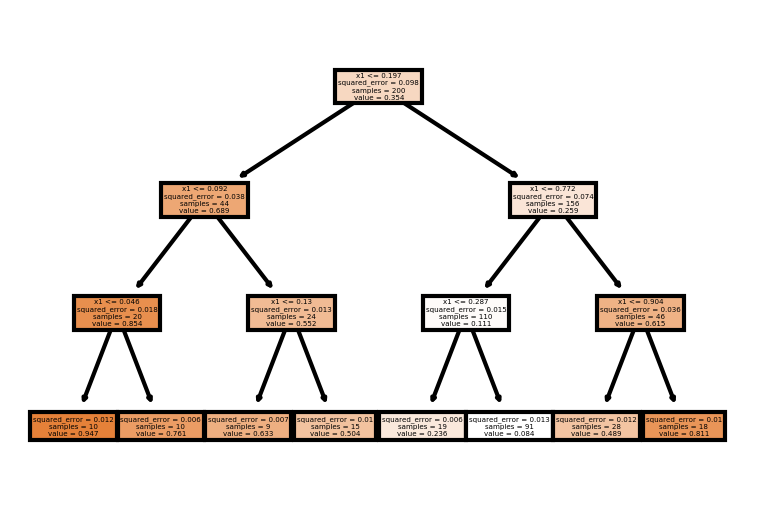

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,2), dpi=300)
tree.plot_tree(tree_reg2,
               feature_names =['x1'], 
               filled = True)

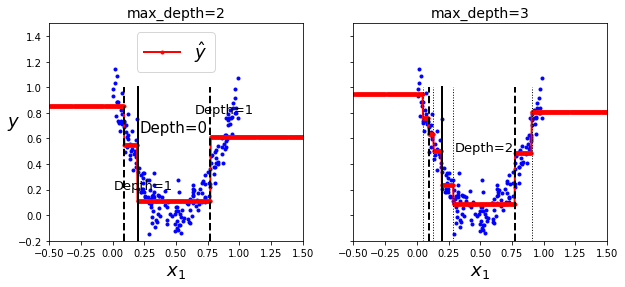

In [ ]:
def plot_regression_predictions(tree_reg, X, y, axes=[-0.5, 1.5, -0.2, 1.5], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

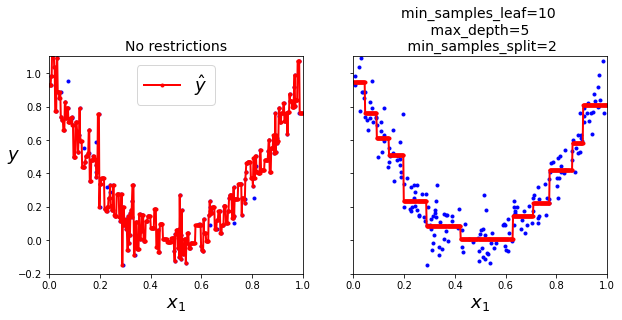

In [ ]:
tree_reg3 = DecisionTreeRegressor(random_state=42)
tree_reg4 = DecisionTreeRegressor(random_state=42,
                                  min_samples_leaf=10,
                                  max_depth = 5,
                                  min_samples_split = 2)
tree_reg3.fit(X, y)
tree_reg4.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg3.predict(x1)
y_pred2 = tree_reg4.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("No restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.title("min_samples_leaf={samples} \n max_depth={depth} \n min_samples_split={split}"
          .format(samples = tree_reg4.min_samples_leaf,
                  depth = tree_reg4.max_depth,
                  split = tree_reg4.min_samples_split), fontsize=14)

plt.show()

Split data set into train/test.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.04551863836734541


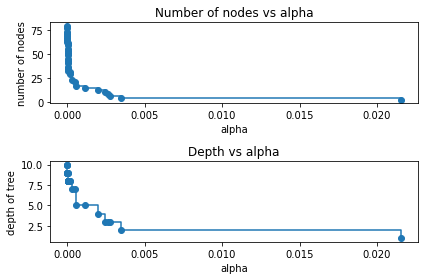

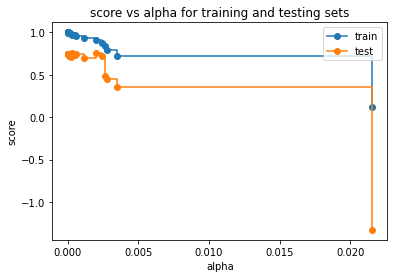

In [ ]:
clf_all = DecisionTreeRegressor(random_state=0)
path = clf_all.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


train_scores = [mean_squared_error(clf.predict(X_train), y_train) for clf in clfs]
test_scores = [mean_squared_error(clf.predict(X_test), y_test) for clf in clfs]

train_scores = [r2_score(clf.predict(X_train), y_train) for clf in clfs]
test_scores = [r2_score(clf.predict(X_test), y_test) for clf in clfs]


fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("score")
ax.set_title("score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

**Find optimal depth of trees**


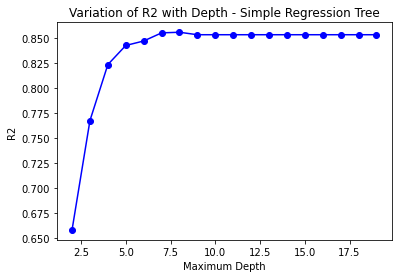

In [ ]:
depth,score_test, tree_start, tree_end = {},{}, 2, 20
for i in range(tree_start, tree_end):
    model = DecisionTreeRegressor(max_depth=i)
    scores_train = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    model.fit(X_train, y_train)
    score_test[i] = r2_score(y_test, model.predict(X_test))
    depth[i] = scores_train.mean()
    
#Plot
lists = sorted(depth.items())
x, y = zip(*lists) 
plt.ylabel("R2")
plt.xlabel("Maximum Depth")
plt.title('Variation of R2 with Depth - Simple Regression Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

Question: Why doesn't $R^2$ converge to 1 as the number of layers increases?

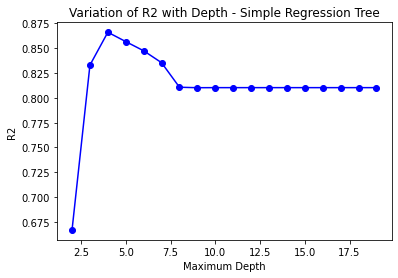

In [ ]:
#Plot
lists = sorted(score_test.items())
x, y = zip(*lists) 
plt.ylabel("R2")
plt.xlabel("Maximum Depth")
plt.title('Variation of R2 with Depth - Simple Regression Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

## Decision tree Playground

Try to fit models, plot results, play with regularization ...

In [ ]:
# Check results from previous tree
print(mean_squared_error(y_test, tree_reg1.predict(X_test))) # max_depth 2
print(mean_squared_error(y_test, tree_reg2.predict(X_test))) # max_depth 3
print(mean_squared_error(y_test, tree_reg3.predict(X_test))) # no regularization
print(mean_squared_error(y_test, tree_reg4.predict(X_test))) # ...


0.020219397967518964
0.011511919901744296
0.0
0.008387874184023876


### ✍🏼 Excercise 1.3

Questions:

* Discuss quality of previous predictions on test sample.
* Discuss Prediction Error vs. Model Complexity in relation to Early stopping and Prunning.
* Use CV to find suboptimal hyperparameters of `DecisionTreeRegressor` to obtain smallest `mse` (or largest `R^2`) on previous simple testing sample.


Your turn:

In [ ]:
# Cross validation
# Check parameters of DecisionTreeRegressor()
params = {'max_leaf_nodes': range(5, 15),
          'min_samples_split': [2, 3, 4, 5],
          'max_depth': range(2, 20)}
grid_search_cv = GridSearchCV(DecisionTreeRegressor(), params, cv=10)
grid_search_cv.fit(X_train, y_train)

print(grid_search_cv.best_params_)
#result = grid_search_cv.cv_results_
#print(result)
print(mean_squared_error(y_test, grid_search_cv.best_estimator_.predict(X_test)))
r2_score(y_test, grid_search_cv.best_estimator_.predict(X_test))

{'max_depth': 7, 'max_leaf_nodes': 14, 'min_samples_split': 3}
0.019333382429704265


0.8081932732631768

**From weak learners to strong one!!!**

# Ensamble models

* Models based on the wisdom of the crowd. 
* Final classification (or regression) is the result of "averaging" the outputs of many weak classifiers. We want to reduce 
* Each simple model is not sufficently good, but all together often outperform a strong method.

The idea of ensambling many models together to produce better forecast has been already mentioned in 1969 in the paper Combination of Forecasts by J.M Bates and C.W.J. Granger.

Ensembling is combining several models with a goal of reaching higher performance.

The simplest approach is to train several independent models and then combine their outputs by
averaging or voting.
The terminology varies, but for classification:
* voting (or hard voting) usually means predicting the class predicted most often by the
individual models,
* averaging (or soft voting) denotes averaging the returned model distributions and predicting the class with the highest probability.

The main idea behind ensembling is that if models have uncorrelated errors, then by averaging
model outputs the errors will cancel out.

correlation/ independent estiamtors/ ...

Ensamble models Classes

* Voting methods
 * Soft/Hard voting
 * Bagging/Pasting
 * Random Forest

* Boosting methods
 * Adaptive boosting
 * Gradient boosting

In [ ]:
# generate 2d classification dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

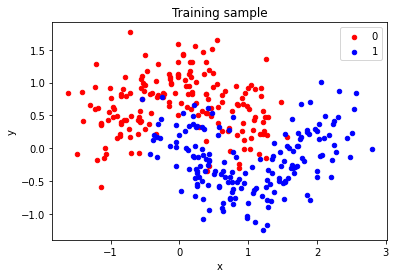

In [ ]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X_train[:,0], y=X_train[:,1], label=y_train))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.title('Training sample')
plt.show()


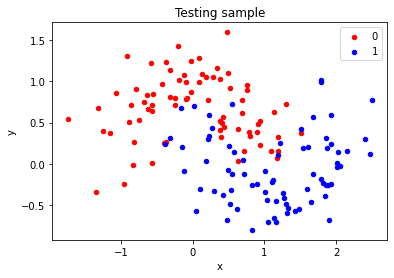

In [ ]:
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=y_test))
colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.title('Testing sample')
plt.show()



### Voting 

Build different "weak classifiers" with uncorrelated error and vote between them.

## ✍🏼 Excercise 2.1

Use classification methods from the last exercise (SVC, KNN, LogisticRegression) together with DecisionTreeClassifier method and write your own Ensamble method with hard voting.

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(solver="lbfgs")
lr_clf.fit(X_train, y_train)

accuracy_score(lr_clf.predict(X_test), y_test)

0.86

In [ ]:
# SVM Classifier model
from sklearn.svm import SVC
svm_clf = SVC( probability=True)
svm_clf.fit(X_train, y_train)

accuracy_score(svm_clf.predict(X_test), y_test)

0.9066666666666666

In [ ]:
# KNN Classifier model
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=2)
knn_clf.fit(X_train, y_train)

accuracy_score(knn_clf.predict(X_test), y_test)

0.8533333333333334

In [ ]:
# Decision Tree model 1
dtc_clf = DecisionTreeClassifier(max_depth = 3)
dtc_clf.fit(X_train, y_train)

accuracy_score(dtc_clf.predict(X_test), y_test)

0.8866666666666667

In [ ]:
# Decision Tree model 2
dtc2_clf = DecisionTreeClassifier(max_depth = 6)
dtc2_clf.fit(X_train, y_train)
accuracy_score(dtc_clf.predict(X_test), y_test)

0.8866666666666667

In [ ]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[('lr', lr_clf),
                ('svc', svm_clf),
                ('knn', knn_clf),
                ('dtc', dtc_clf),
                ('dtc2', dtc2_clf)
                ],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (lr_clf, knn_clf, svm_clf, dtc_clf, dtc2_clf,voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.86
KNeighborsClassifier 0.8533333333333334
SVC 0.9066666666666666
DecisionTreeClassifier 0.8866666666666667
DecisionTreeClassifier 0.8666666666666667
VotingClassifier 0.92


## Bagging and Pasting

Bagging (Bootstrap aggregating) was proposed by Leo Breiman in 1994 to improve the classification by combining classifications of randomly generated training sets.  
* Bagging is a special case of the ensamble modeles with averaging approach.
* Bagging (sampling with replacement) is a technique for reducing the estimation error of a predictor.  
* It produce different dataset for every model to be trained by sampling from the same emperical distribution given by the training dataset.
* This ensemble of trees with different “initial conditions” is more robust to noise and outliers. 
* It can dramatically reduce the variance of unstable methods (like trees), leading to improved prediction, however any simple, interpretable, model structure (like that of a tree) is lost.

* Pasting: sampling without replacement

   



Lets built bootstrap and vote method by hand:

In [ ]:
from sklearn.utils import resample
#Initialization
n_trees = 500     # Hyperparameter to tune
max_dep = 5       # Hyperparameter to tune
max_samples = 150 # Hyperparameter to tune
predictions_train = np.zeros((X_train.shape[0], n_trees))
predictions_test  = np.zeros((y_test.shape[0], n_trees))

# Used model
model = DecisionTreeClassifier(max_depth=max_dep) # we can try a variety of depths here

#Bootstrap
for i in range(n_trees):
    X_bs, y_bs = resample(X_train, y_train, replace=True)
    X_bs = X_bs[:max_samples]
    y_bs = y_bs[:max_samples]

    model.fit(X_bs, y_bs)
    predictions_train[:,i] = model.predict(X_train)   
    predictions_test[:,i] = model.predict(X_test)
    

#Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)



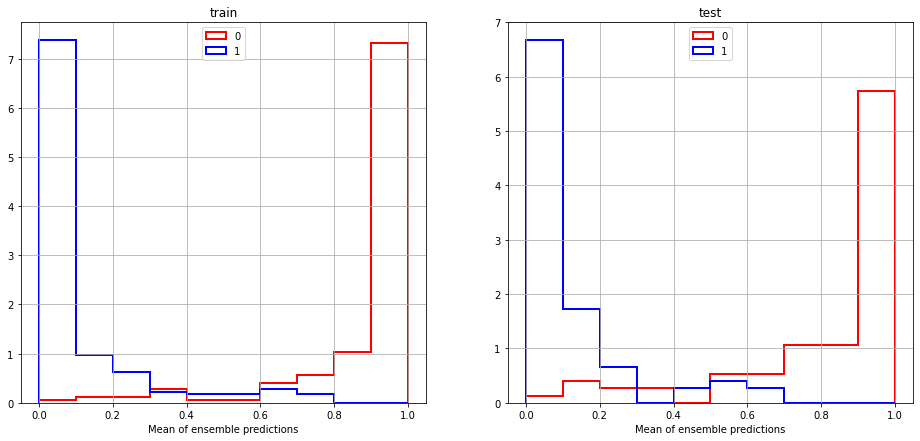

In [ ]:
num_to_avg = 100 # we varied this line, from 1, 2, 3, 100, n_trees
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for (ax, label, predictions, y) in [
    (axs[0], 'train', predictions_train, y_train), 
    (axs[1], 'test', predictions_test, y_test)
]:
    mean_predictions = predictions.iloc[:,:num_to_avg].mean(axis=1)
    mean_predictions[y == 1].hist(density=True, histtype='step', range=[0,1], label='0', lw=2, ax=ax, color="red")
    mean_predictions[y == 0].hist(density=True, histtype='step', range=[0,1], label='1', lw=2, ax=ax, color = "blue")
    ax.legend(loc='upper center');
    ax.set_xlabel("Mean of ensemble predictions")
    ax.set_title(label)

Final hard voting ensamble model:

In [ ]:
#Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df, count=-1):
    count = df.shape[1] if count==-1 else count
    temp = df.iloc[:,0:count]
    return np.mean(temp, axis=1)>0.5

#Check Accuracy of Spam Detection in Train and Test Set
print("Accuracy, Training Set :", str(100*accuracy_score(y_train, get_prediction(predictions_train, count=-1)))+'%')
print("Accuracy, Testing Set :", str(100*accuracy_score(y_test, get_prediction(predictions_test, count=-1)))+'%')

Accuracy, Training Set : 94.0%
Accuracy, Testing Set : 91.33333333333333%


Use scikit-learn function `BaggingClassifier`

In [ ]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs = -1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

#Check Accuracy of Spam Detection in Train and Test Set
print("Accuracy, Training Set :", str(100*accuracy_score(y_train, bag_clf.predict(X_train)))+'%')
print("Accuracy, Testing Set :", str(100*accuracy_score(y_test, bag_clf.predict(X_test)))+'%')

Accuracy, Training Set : 94.0%
Accuracy, Testing Set : 92.0%


In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.8533333333333334


**Bagging produces smoother decision boundaries than trees.**

In [ ]:
X, y =  make_circles(n_samples=250, shuffle=True, noise=0.15, random_state=None, factor=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=200,
    max_samples=50, bootstrap=True, n_jobs = -1, random_state=42)
bag_clf.fit(X_train, y_train)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 1.5, -1.5, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

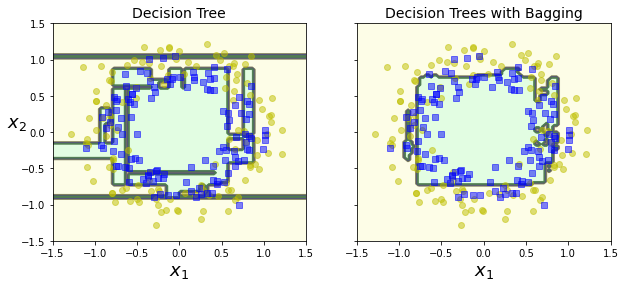

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

**OOB: out of bag samples:**  
In bagging procedure, some observations are sampled several times, while others may nt be sampled at all.

If max_samples is equal to the size of the training set, only 63% instances are sampled on average for each predictor, the remaining instances are called out-of-bag.

Evaluation of the ensamble can be computed by averaging out the oob evaluations of each predictor.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)
accuracy_score(y_train, bag_clf.predict(X_train))

0.6914285714285714


1.0

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.6533333333333333

## Random Forest

* Optimized model that combines Bagging with Decision Trees.
* Collections of trees that are constructed to be decorrelated, so that using them to vote gives maximal advantage. 
* In competitions, they often have very good classification performance among large collections of much fancier methods.


In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(np.sum(y_pred == y_pred_rf) / len(y_pred))
print(accuracy_score(y_test, y_pred_rf))
print(accuracy_score(y_test, y_pred))

0.9733333333333334
0.68
0.68


# Boosted Trees

Another way of building an ensamble model is creates a sequence of weak methods with the idea, that later models should correct the mistake of earlier models.

More computational cost, but we have no problem with today's resources.

Harder to paralize compare to bagging.

## Adaptive boosting aka Adaboost

Adaboost adds predictors to the ensamble and gradually making it better. Since the algorithm build the ensamble step-by-step it can not be parallized.
Adaboost algorithm was formulated by Yoav Freund and Robert Schapire in 1996.


Algorithm:  
Each instance weight $w^{(i)}$ is initially set to $\frac{1}{m}$. First predictor is trained and its weighted error rate $r_1$ is computed:  
$$r_j = \frac{\sum_{i=1 , \hat{y}_j^{(i)} \neq y^{(i)}}^{m} w^{(i)}}{\sum_{i=1}^m w^{(i)}},$$
where $\hat{y}_j^{(i)}$ is the $j^{th}$ predictor's prediction for the $i^{th}$ observatiion.  
Predictor weight $\alpha_j$ is computed in the next step by
$$\alpha = \eta \frac{1-r_j}{r_j},$$
where $\eta$ is learning rate hyperparameter. Next the instance weights are updated for $i = 1,2, \ldots, m$:
$$w^{(i)} = w^{(i)} \ \ if \ \ \hat{y}_j^{(i)} = y^{(i)}$$ and
$$w^{(i)} = w^{(i)} e^{\alpha_j} \ \ if \   \ \hat{y}_j^{(i)} \neq y^{(i)}.$$ 
All the instance weights are normalized by $\sum_{i=1}^m w^{(i)}$. Finally,
a new predictor is trained using all updated weights and the whole process is repated.

To make predictions, Adaboost computes the predictions of all predictors and weights them using the predictor weights $\alpha_j$
$$\hat{y}(X) =  \text{argmax}_k \sum_{j=1, \hat{y}_j(X) = k}^N \alpha_j $$

In scikit-learn is implemented versions called SAMME (Stage Additive Modeling a Multicalss Exponential loss function).




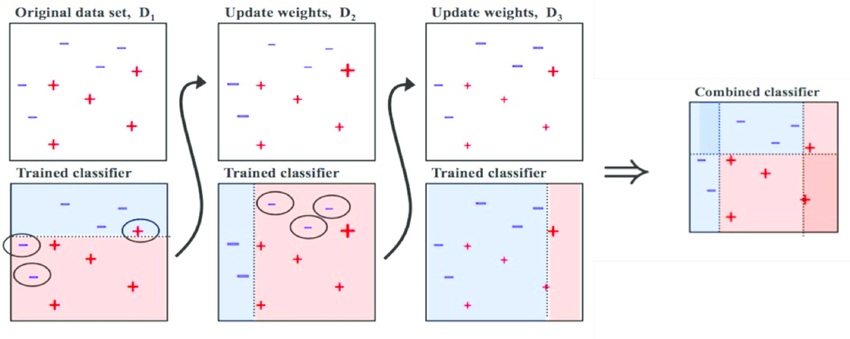


Source: https://www.researchgate.net/publication/306054843_Multivariate_Analysis_of_the_Vector_Boson_Fusion_Higgs_Boson

In [ ]:
#Fit an Adaboost Model with DecisionTreeClassifier()
from sklearn.ensemble import AdaBoostClassifier

#Training
model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,  max_leaf_nodes=20),
                           n_estimators=25,
                           learning_rate=0.05)
model.fit(X_train, y_train)

model2 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),
                            n_estimators=50,
                            algorithm="SAMME.R",
                            learning_rate=0.2,
                            random_state=42)
model2.fit(X_train, y_train)

#Predict
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Accuracy, Training Set :",str(train_score)+'%')
print("Accuracy, Testing Set :",str(test_score)+'%')
print("Accuracy model2, Testing Set  :",str(accuracy_score(y_test, model2.predict(X_test))*100)+'%')

Accuracy, Training Set : 88.57142857142857%
Accuracy, Testing Set : 70.66666666666667%
Accuracy model2, Testing Set  : 57.333333333333336%


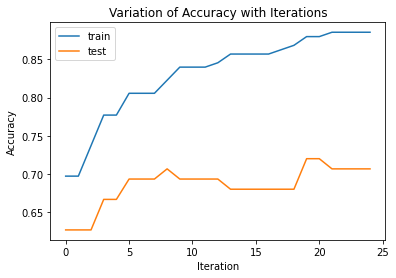

In [ ]:
#Plot Iteration based score
train_scores = list(model.staged_score(X_train,y_train))
test_scores = list(model.staged_score(X_test, y_test))

plt.plot(train_scores,label='train')
plt.plot(test_scores,label='test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title("Variation of Accuracy with Iterations")
plt.legend();



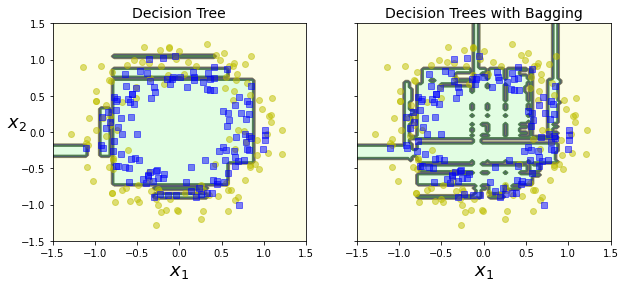

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(model, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(model2, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

Finally ;-)

## Gradient boosting

Gradient Boosting 

As all boosting methods, Gradient Boosted Decision Tree (GBDT) is building the ensamble of models iteratively by correcting the errors of the previous step. 

An ensemble of weak simple models $\{T_h\}_{h \in H}$ are additively combine into a single strong and more complex model.

Each model $T_h$ might has a poor fit on the data, but a linear combination 
of the ensemble 
$$T = \sum_{h} \lambda_h T_h $$
is flexible and it can produce very good results.

1. Fit a simple model $𝑇^{(0)}$ on the training data $(x_1 , y_1), \ldots (x_N , y_N )$ Set $T^{(0)}  \to T$  and compute the residuals ${r_1 , \ldots, r_N }$ for $T$. 
2. Fit a  model $𝑇^{(1)}$  to the current residuals, i.e. train using
$(x_1,r_1) , \ldots, (x_N,r_N)$.
3. Set $𝑇 + \lambda 𝑇^{(1)} \to T$
4. Compute residuals and set $r_n − 𝜆𝑇^{(i)}(x_n)$  $𝑛 = 1, \ldots , 𝑁$, where $\lambda$ is a constant called the learning rate (step size). 
5. Repeat steps 2-4 until stopping condition met.

With learning rate = 1 we obtain low bias but high variance model !!

Why the algorithm converge?

Each simple model $T^{(i)}$  added to the ensemble model $T$, models the errors of $T$. With each addition of $T^{(i)}$, the residual is reduced $r_n - \lambda T^{(i)} (x_n)$

Since $MSE(\hat{y}_1, \ldots, \hat{y}_N) = \frac{1}{N} \sum_{i=1}^N (\hat{y}_i - {y}_i)^2$ then $ d MSE \ dy = -2(r_1, \ldots, r_N)$ and update for gradient descent is: $\hat{y}_n + \lambda_n r_n \to \hat{y}_n.$



Note that gradient boosting has a tuning parameter, 𝜆. 
If we want to easily reason about how to choose 𝜆 and investigate the 
effect of 𝜆 on the model T, we need a bit more mathematical formalism. 
In particular, how can we effectively descend through this optimization 
via an iterative algorithm?
We need to formulate gradient boosting as a type of gradient descent

Lets use again function from  O'Reilly book Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow: https://github.com/ageron/handson-ml2


In [ ]:
# Let create a simple quadratic dataset:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

Now let's train a decision tree regressor on this dataset:

In [ ]:
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [ ]:
y_pred

array([0.75026781])

The first predictor (top left) is trained normally, then each consecutive predictor (middle left and lower left) is trained on the previous predictor’s residuals; the right column shows the resulting ensemble’s predictions:

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

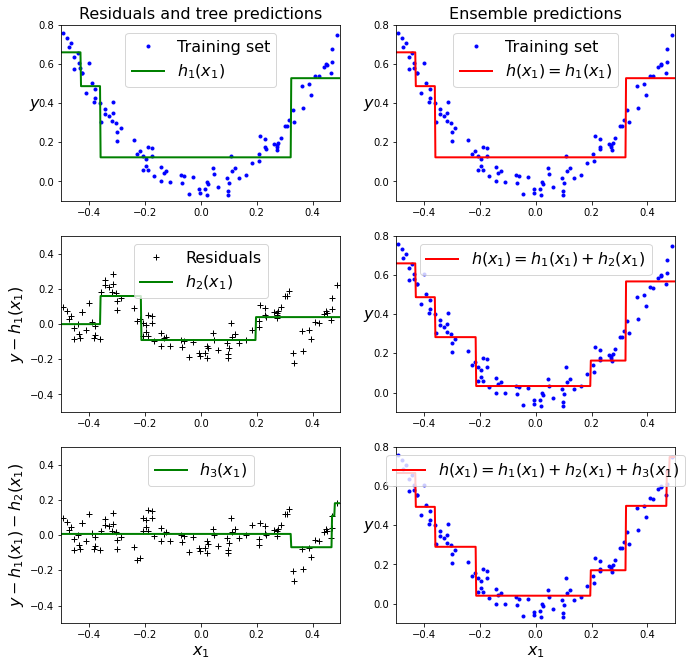

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.show()

Now let's try a gradient boosting regressor:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

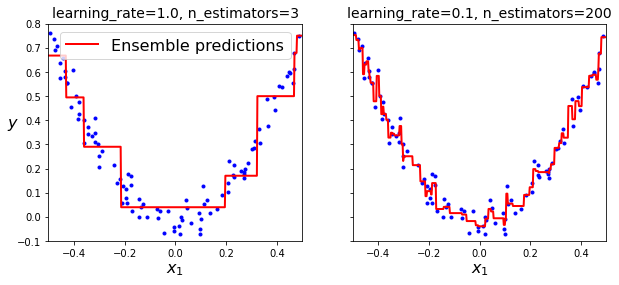

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.show()

Question: Which model do you prefere and why?

**Gradient Boosting with Early stopping:**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

 Tuning the number of trees using early stopping:

In [ ]:
min_error = np.min(errors)

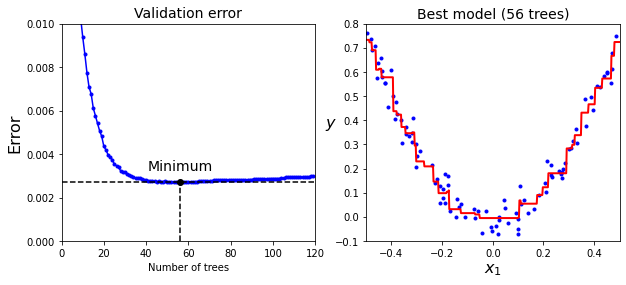

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Early stopping with some patience (interrupts training only after there's no improvement for 5 epochs):

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)

61


In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


**Using XGBoost:**

In [ ]:
import xgboost

In [ ]:
 xgb_reg = xgboost.XGBRegressor(random_state=42)
 xgb_reg.fit(X_train, y_train)
 y_pred = xgb_reg.predict(X_val)
 val_error = mean_squared_error(y_val, y_pred) 
 print("Validation MSE:", val_error)           

[07:12:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [ ]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred)  
print("Validation MSE:", val_error)          

[07:04:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.288758
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.261177
[2]	validation_0-rmse:0.238346
[3]	validation_0-rmse:0.216032
[4]	validation_0-rmse:0.196391
[5]	validation_0-rmse:0.17888
[6]	validation_0-rmse:0.164617
[7]	validation_0-rmse:0.150426
[8]	validation_0-rmse:0.138797
[9]	validation_0-rmse:0.128337
[10]	validation_0-rmse:0.119538
[11]	validation_0-rmse:0.111472
[12]	validation_0-rmse:0.103879
[13]	validation_0-rmse:0.097429
[14]	validation_0-rmse:0.092161
[15]	validation_0-rmse:0.086732
[16]	validation_0-rmse:0.082709
[17]	validation_0-rmse:0.078897
[18]	validation_0-rmse:0.075979
[19]	validation_0-rmse:0.071398
[20]	validation_0-rmse:0.069059
[21]	validation_0-rmse:0.067178
[22]	validation_0-rmse:0.065349
[23]	validation_0-rmse:0.062347
[24]	validation_0-rmse:0.060949
[25]	validation_0-rm

In terms of model performance, we have the following heirarchy:

**Boosting > RandomForest > Bagging > SingleTree**

#### Other boosting methods:  
* LightGBM (Microsoft)
* CatBoost (Yandex)

If you have enough time and resources, you can use Xgboost, but these other methods are good to use in Stacking (Blending) method.

https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc

LigthGBM is faster, but both LightGBM and XGB can use histogram based algorith now. But still LightGBM has faster training speed and lower memory usage.

It's implemented in scikit-learn as well :-D

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgb_reg = HistGradientBoostingRegressor(random_state=42)
hgb_reg.fit(X_train, y_train)
y_pred = hgb_reg.predict(X_val)
val_error = mean_squared_error(y_val, y_pred) 
print("Validation MSE:", val_error)  

Validation MSE: 0.0158081410814983


## Stacking

Stacking is based on ona simple idea. Instead of using trival functions, such as hard voting, to agregate and choose fnal prediction, we can use advancd model to perform this agregation.



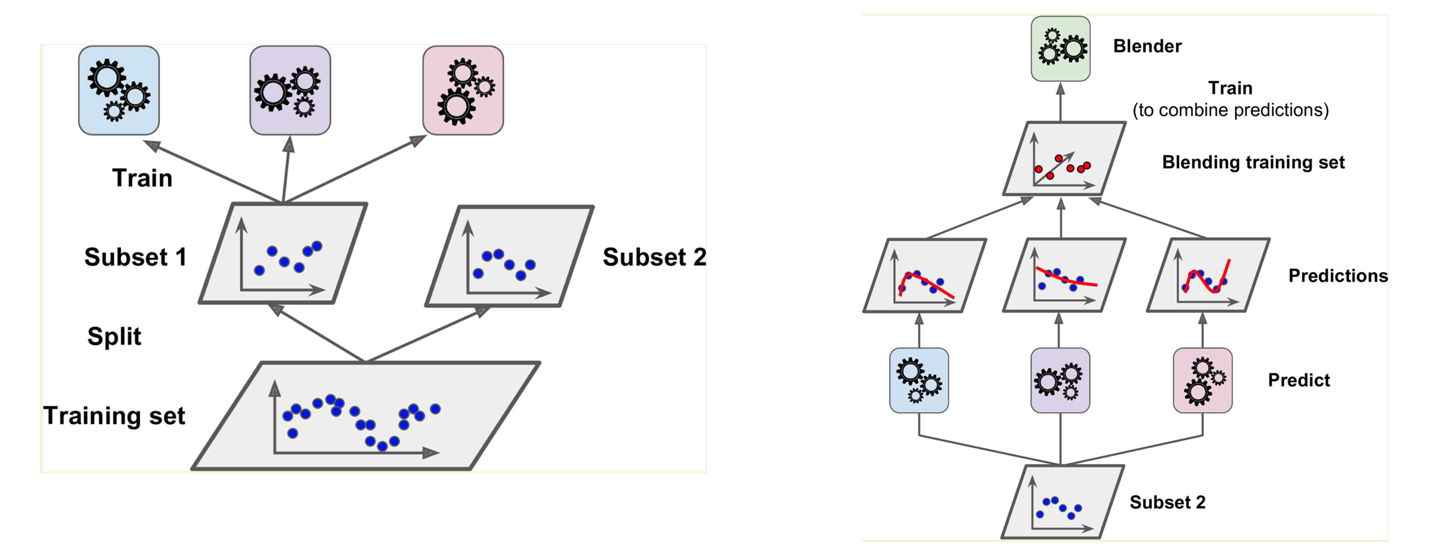

## ✍🏼 Excercise 2.2

Questions:  

* Compare advantages and disadvanteges of Regression deccision trees vs. Linear methods.
* Can we use Decision Trees methods for predicting Time Series?
* Can we use Decision Trees methods for Image classification?
* When we use Shuffle and when Stratify train/test split?
* Can scaling of dataset improve the performance of Decision Tree method?
* Can some transormation improve the performance of Decision Tree method?



# Pipelines in Scikit-Learn

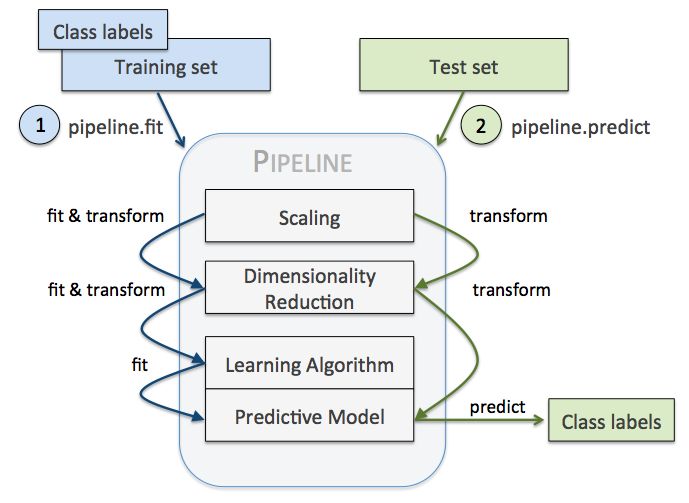

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector 
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

#from catboost import CatBoostRegressor, Pool


In [ ]:
# Diabetes dataset (reals, regression)

# Load the example datasets
# https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset

from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
#y = pd.DataFrame(diabetes.target)
y = diabetes.target

X.info()
X.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
dtypes: float64(10)
memory usage: 34.7 KB


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.639623e-16,1.309912e-16,-8.013951e-16,1.289818e-16,-9.042540e-17,1.301121e-16,-4.563971e-16,3.863174e-16,-3.848103e-16,-3.398488e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


In [ ]:
# split the dataframe to train and test parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# lets create Gradient Boosting model

num_transformer = Pipeline(steps=[
                  ('scaler', RobustScaler())])

cat_transformer = Pipeline(steps=[
                  ('onehot', OneHotEncoder(categories='auto', 
                                     sparse=False, 
                                     handle_unknown='ignore'))])

num_selector = make_column_selector(dtype_include=np.number)
cat_selector = make_column_selector(dtype_include=object)

pipeline_preprocess = ColumnTransformer(transformers=[
        ('numerical_preprocessing', num_transformer, num_selector),
        ('categorical_preprocessing', cat_transformer, cat_selector)],
        remainder='passthrough')

pipe = Pipeline([("transform_inputs", pipeline_preprocess), ("reg", GradientBoostingRegressor())])

param_grid = {'reg__max_features': ['auto', 'sqrt'],
              'reg__subsample': [0.1, 0.05, 0.4],
              'reg__min_samples_leaf': [0.0025, 0.005, 0.01, 0.05, 0.1],
              'reg__n_estimators':[30, 40, 50, 70, 200]}
model = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5, scoring='r2').fit(X_train, y_train)

y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_mae = mean_absolute_error(y_pred, y_test)
model_r2  = model.best_estimator_.score(X_test, y_test)

print(f"Model mse: {model_mse} \n")
print(f"Model mae: {model_mae} \n")
print(f"Model R2: {model_r2} \n")
print(f"Model hyper_params: {model.best_params_}")

Model mse: 2846.111436722721 

Model mae: 42.96126982315682 

Model R2: 0.47277710677828755 

Model hyper_params: {'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 0.0025, 'reg__n_estimators': 30, 'reg__subsample': 0.4}


[05:47:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0.03181779 0.0728816  0.09544469 0.05602308 0.04318665 0.04395618
 0.04599226 0.04234416 0.5066233  0.06173028]


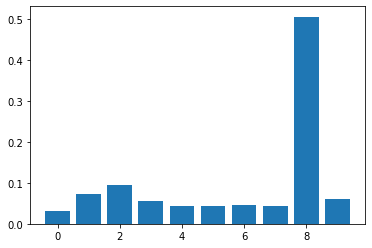

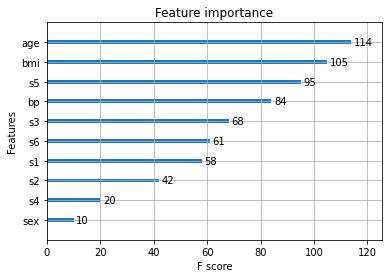

In [ ]:
# Feature selection and feature importance
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
from xgboost import plot_importance, XGBRegressor, XGBClassifier

model = XGBRegressor()
model.fit(X_test, y_test)
# feature importance
print(model.feature_importances_)
# plot eature importance
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

# plot feature importance
plot_importance(model)
plt.show()

#  ✍🏼 Final Excercise 3.1

*  Use the diabetes dataset from sklearn.
*  Split it into train and validation set.
*  Train various regression metods: RandomForest, Gradient Boosted method, ...
*  Use CV and gridsearch to optimize hyperparameters for selected methods.
* Try to combine your estimators to Ensamble one that outperform each individual predictor.
* Use averaging and blending approach.


Inspiration: https://www.programcreek.com/python/example/85913/sklearn.datasets.load_diabetes

## Interpretation of features

* https://christophm.github.io/interpretable-ml-book/

* https://learn-scikit.oneoffcoder.com/shap.html

* https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d


In [ ]:
!pip install -q shap #shap is not installed in colab
import shap
shap.initjs() # Initialize our Jupyter notebook with initjs()

In [ ]:
rnd_reg = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_reg.fit(X_train, y_train)

y_pred = rnd_reg.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)

print(f"Model mse: {model_mse} \n")


Model mse: 2768.1429510759835 



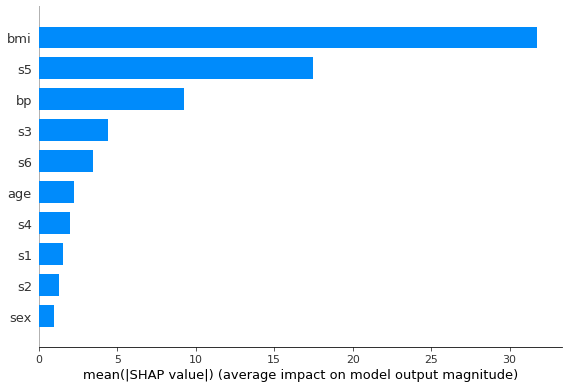

In [ ]:
explainer = shap.TreeExplainer(rnd_reg)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

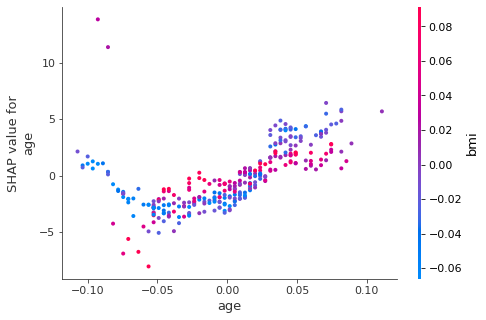

In [ ]:
shap.dependence_plot("age", shap_values, X_train)

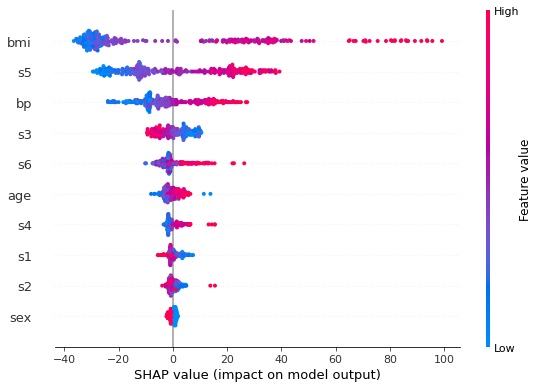

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X_train)

In [ ]:
# Write in a function
def shap_plot(j,model,S):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

In [ ]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
225,0.030811,0.050680,0.032595,0.049415,-0.040096,-0.043589,-0.069172,0.034309,0.063017,0.003064
412,0.074401,-0.044642,0.085408,0.063187,0.014942,0.013091,0.015505,-0.002592,0.006209,0.085907
118,-0.056370,0.050680,-0.010517,0.025315,0.023198,0.040022,-0.039719,0.034309,0.020612,0.056912
114,0.023546,-0.044642,0.110198,0.063187,0.013567,-0.032942,-0.024993,0.020655,0.099240,0.023775
364,0.001751,0.050680,-0.006206,-0.019442,-0.009825,0.004949,-0.039719,0.034309,0.014823,0.098333


Explanation of each observation:

In [ ]:
shap.initjs() # Javascript need in each cell !!!
shap_plot(0,rnd_reg,X_train)